# Azure AI Agent service - Code interpreter

<img src="https://learn.microsoft.com/en-us/azure/ai-services/agents/media/agent-service-the-glue.png" width=800>

> https://learn.microsoft.com/en-us/azure/ai-services/agents/

In [1]:
#%pip install ipyplot
#%pip install matplotlib

## Load all dependencies

In [2]:
import glob
import json
import ipyplot
import matplotlib.pyplot as plt
import os
import sys
import time

from azure.ai.agents import AgentsClient 
from azure.identity import DefaultAzureCredential
from azure.ai.agents.models import CodeInterpreterTool, FilePurpose, ListSortOrder
from dotenv import load_dotenv
from openai import AzureOpenAI
from PIL import Image
from pathlib import Path

In [3]:
load_dotenv()

True

## Connect to AI Foundry Project 

In [4]:
endpoint = os.getenv("PROJECT_ENDPOINT")
print(f"Using endpoint: {endpoint}")
credential = DefaultAzureCredential()

project_client = AgentsClient(endpoint=endpoint, credential=credential)

Using endpoint: https://aq-ai-foundry-sweden-central.services.ai.azure.com/api/projects/firstProject


## Get example file

In [5]:
DATA_DIR = "data"

os.makedirs(DATA_DIR, exist_ok=True)

output_file = os.path.join(DATA_DIR, "titanic.csv")

In [6]:
!wget https://raw.githubusercontent.com/datasciencedojo/datasets/refs/heads/master/titanic.csv -O $output_file

--2025-06-13 16:43:12--  https://raw.githubusercontent.com/datasciencedojo/datasets/refs/heads/master/titanic.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60302 (59K) [text/plain]
Saving to: ‘data/titanic.csv’

data/titanic.csv    100%[===================>]  58.89K  --.-KB/s    in 0.01s   

2025-06-13 16:43:12 (5.12 MB/s) - ‘data/titanic.csv’ saved [60302/60302]



In [7]:
model = "gpt-4o-mini"

## Upload file to agent

In [8]:
file = project_client.files.upload_and_poll(file_path=output_file,
                                                  purpose=FilePurpose.AGENTS)

print(f"Uploaded file, file ID: {file.id}")

Uploaded file, file ID: assistant-SG58niGDVNKnT4r2yoPdFy


## Create and agent with code interpreter tool

In [ ]:
code_interpreter = CodeInterpreterTool(file_ids=[file.id])

# Create agent with code interpreter tool and tools_resources
agent = project_client.create_agent(
    model=os.environ["MODEL_DEPLOYMENT_NAME"],
    name="my-agent",
    instructions="You are helpful agent",
    tools=code_interpreter.definitions,
    tool_resources=code_interpreter.resources,
)
print(f"Created agent, agent ID: {agent.id} File ID: {file.id}")

Created agent, agent ID: asst_qNiY8ULMtJ2DPy0wKLyN2OZp File ID: assistant-SG58niGDVNKnT4r2yoPdFy


## Create a thread for the agent to run

In [10]:
# create a thread
thread = project_client.threads.create()
print(f"Created thread, thread ID: {thread.id}")

prompt = "Plot a correlation matrix using the blues theme"

# create a message
message = project_client.messages.create(
    thread_id=thread.id,
    role="user",
    content=prompt,
)
print(f"Created message, message ID: {message.id}")

messages = project_client.messages.list(thread_id=thread.id)
print(f"Messages: {messages}")

Created thread, thread ID: thread_icC2UMpEmtYS6LnF45l1bpoL
Created message, message ID: msg_gl18XAfjB6T6pVkekM1qxAx4
Messages: <iterator object azure.core.paging.ItemPaged at 0x1172b17f0>


## Run the code interpreter agent

In [11]:
# create a run for the agent
run = project_client.runs.create_and_process(thread_id=thread.id,
                                                   agent_id=agent.id)
print(f"Created run, run ID: {run.id}")

Created run, run ID: run_IZJ7YINXWpHoSK726iWuTN73


## Get the messages generated by the run

In [12]:
messages = project_client.messages.list(thread_id=thread.id)
print(f"Messages: {messages}")

# Fetch and log all messages
messages = project_client.messages.list(thread_id=thread.id, order=ListSortOrder.ASCENDING)

# Print last messages from the thread
for msg in messages:
    if msg.text_messages:
        last_text = msg.text_messages[-1]
        print(f"{msg.role}: {last_text.text.value}")

Messages: <iterator object azure.core.paging.ItemPaged at 0x117275bd0>
MessageRole.USER: Plot a correlation matrix using the blues theme
MessageRole.AGENT: I will first read the file to inspect its contents. Then, I'll plot the correlation matrix using a blue color theme.

Let's start by examining the data.
MessageRole.AGENT: The data is from the Titanic dataset. I will now compute the correlation matrix for the numerical columns and plot it using a blue-themed heatmap.
MessageRole.AGENT: Here is the correlation matrix for the numerical columns in your dataset, visualized using a blue-themed heatmap. If you need further analysis on specific columns or want to include other types of features, let me know!


## Save image(s) generated by the run

In [13]:
IMAGES_DIR = "images"

images_list = []

# [START get_messages_and_save_files]
messages = project_client.messages.list(thread_id=thread.id)
print(f"Messages: {messages}")

for msg in messages:
        # Save every image file in the message
        for img in msg.image_contents:
            file_id = img.image_file.file_id
            file_name = f"./images/{file_id}_image_file.png"
            project_client.files.save(file_id=file_id, file_name=file_name)
            print(f"Saved image file to: {Path.cwd() / file_name}")

        # Print details of every file-path annotation
        for ann in msg.file_path_annotations:
            print("File Paths:")
            print(f"  Type: {ann.type}")
            print(f"  Text: {ann.text}")
            print(f"  File ID: {ann.file_path.file_id}")
            print(f"  Start Index: {ann.start_index}")
            print(f"  End Index: {ann.end_index}")
        # [END get_messages_and_save_files]
        # Print last messages from the thread
        for msg in messages:
            if msg.text_messages:
                last_text = msg.text_messages[-1]
                print(f"{msg.role}: {last_text.text.value}")


Messages: <iterator object azure.core.paging.ItemPaged at 0x1172c43e0>
Saved image file to: /Users/arturoquiroga/GITHUB/AZURE AI AGENT SERVICE/1_Azure Agent Service/NOTEBOOKS/images/assistant-JhGttdRj7GC9zG14sKdFLQ_image_file.png
MessageRole.AGENT: The data is from the Titanic dataset. I will now compute the correlation matrix for the numerical columns and plot it using a blue-themed heatmap.
MessageRole.AGENT: I will first read the file to inspect its contents. Then, I'll plot the correlation matrix using a blue color theme.

Let's start by examining the data.
MessageRole.USER: Plot a correlation matrix using the blues theme


## Display image

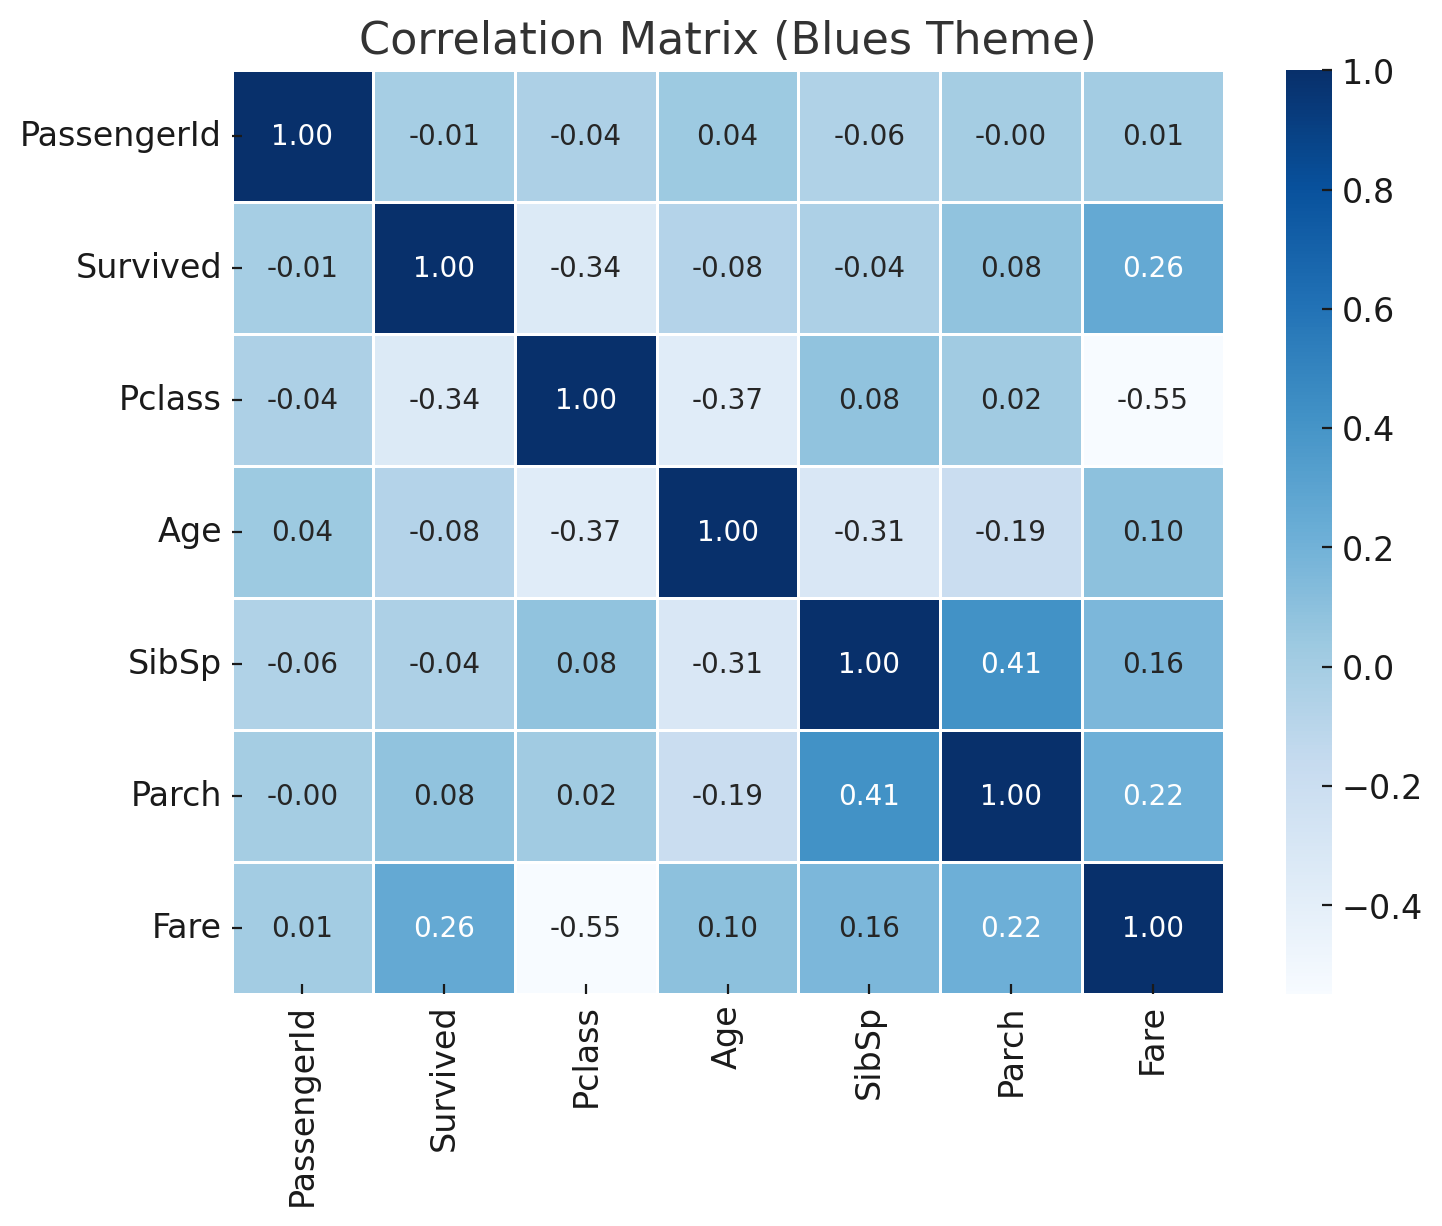

In [14]:
from IPython.display import Image, display
from pathlib import Path

file_id = img.image_file.file_id
file_name = f"./{file_id}_image_file.png"
file_path = Path.cwd() / file_name
display(Image(filename=str(file_path)))


## Example

In [15]:
# create a thread
thread = project_client.threads.create()
print(f"Created thread, thread ID: {thread.id}")

prompt = "Generate a bivariate analysis of survival and pclass. Use some greens colors."

# create a message
message = project_client.messages.create(
    thread_id=thread.id,
    role="user",
    content=prompt,
)
print(f"Created message, message ID: {message.id}")

Created thread, thread ID: thread_lzO4rYuE5wySxSDpklmKqCQN
Created message, message ID: msg_siZhGAAJl0ttz77hXFgtRgig


In [16]:
# create a run for the agent
run = project_client.runs.create_and_process(thread_id=thread.id,
                                                   agent_id=agent.id)
print(f"Created run, run ID: {run.id}")

Created run, run ID: run_Gb90UfXbDQg3NOFxEkp0A7dE


In [17]:
run.usage

{'prompt_tokens': 2989, 'completion_tokens': 509, 'total_tokens': 3498, 'prompt_token_details': {'cached_tokens': 0}}

In [18]:
    IMAGES_DIR = "images"

    images_list = []

    # [START get_messages_and_save_files]
    messages = project_client.messages.list(thread_id=thread.id)
    print(f"Messages: {messages}")

    for msg in messages:
        # Save every image file in the message
        for img in msg.image_contents:
            file_id = img.image_file.file_id
            file_name = f"{file_id}_image_file.png"
            project_client.files.save(file_id=file_id, file_name=file_name)
            print(f"Saved image file to: {Path.cwd() / file_name}")

        # Print details of every file-path annotation
        for ann in msg.file_path_annotations:
            print("File Paths:")
            print(f"  Type: {ann.type}")
            print(f"  Text: {ann.text}")
            print(f"  File ID: {ann.file_path.file_id}")
            print(f"  Start Index: {ann.start_index}")
            print(f"  End Index: {ann.end_index}")
        # [END get_messages_and_save_files]
        # Print last messages from the thread
        for msg in messages:
            if msg.text_messages:
                last_text = msg.text_messages[-1]
                print(f"{msg.role}: {last_text.text.value}")

Messages: <iterator object azure.core.paging.ItemPaged at 0x1172c4510>
Saved image file to: /Users/arturoquiroga/GITHUB/AZURE AI AGENT SERVICE/1_Azure Agent Service/NOTEBOOKS/assistant-LUJpNHdsLTzN4nsQjtkix5_image_file.png
MessageRole.AGENT: The dataset contains the columns **Survived** and **Pclass** as requested.

Now, I’ll create a bivariate analysis (cross-tabulation and visualization) of survival rates by passenger class using green color gradients for easy interpretation.
MessageRole.AGENT: Sure! I’ll perform a bivariate analysis between the variables **Survived** and **Pclass** using your uploaded file. I’ll visualize the results using a green color palette to make it easy to interpret.

First, I’ll take a quick look at the file contents to identify column names and ensure compatibility.
MessageRole.USER: Generate a bivariate analysis of survival and pclass. Use some greens colors.


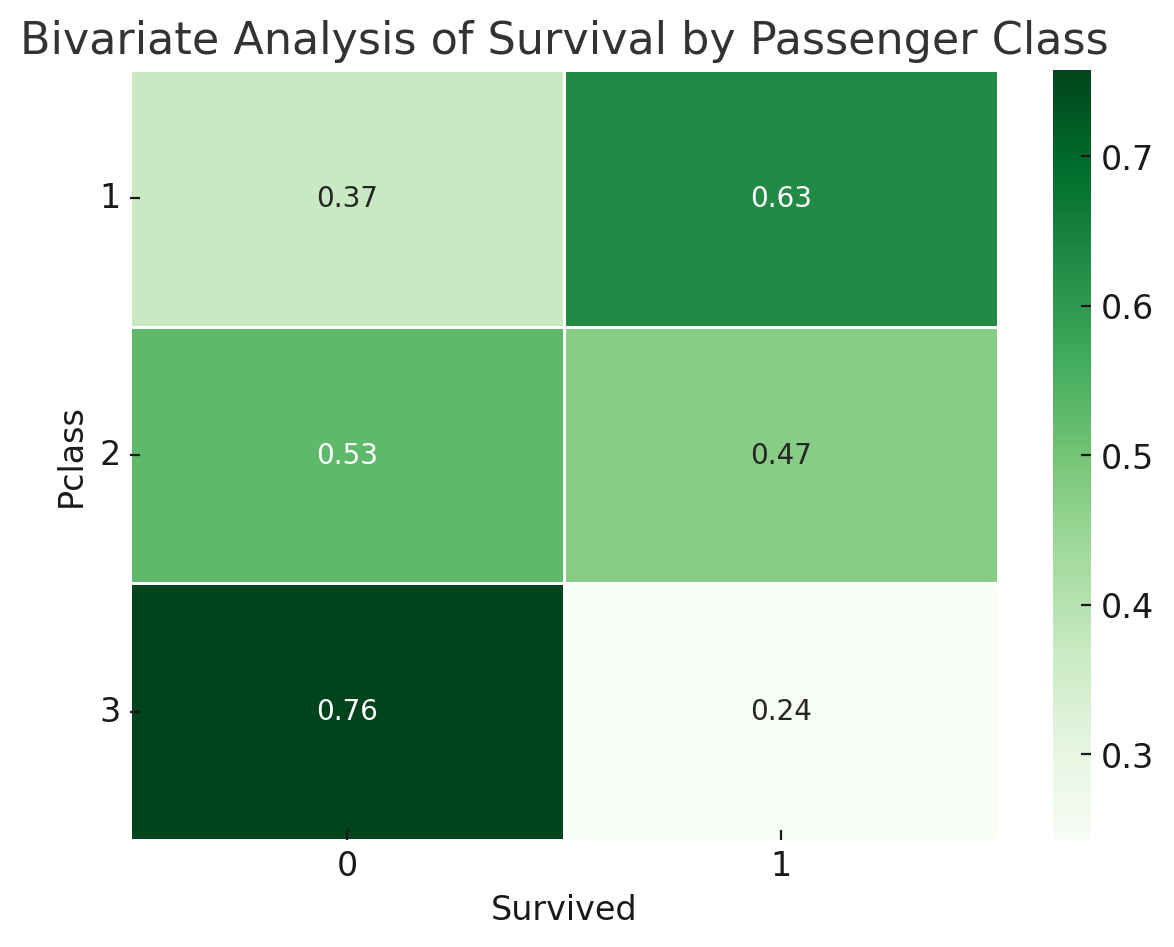

In [19]:
from IPython.display import Image, display
from pathlib import Path

file_id = img.image_file.file_id
file_name = f"./{file_id}_image_file.png"
file_path = Path.cwd() / file_name
display(Image(filename=str(file_path)))

## Example

In [20]:
# create a thread
thread = project_client.threads.create()
print(f"Created thread, thread ID: {thread.id}")

prompt = "Generate a violin plot of Pclass by Age and Gender. Use lime and cyan colors."

# create a message
message = project_client.messages.create(
    thread_id=thread.id,
    role="user",
    content=prompt,
)
print(f"Created message, message ID: {message.id}")

Created thread, thread ID: thread_eZXVv3zqY0PkLcfn4O0Hc5Gf
Created message, message ID: msg_4rojDTqgjq8GcC9O0UGL3SfW


In [21]:
# create a run for the agent
run = project_client.runs.create_and_process(thread_id=thread.id,
                                                   agent_id=agent.id)
print(f"Created run, run ID: {run.id}")

run.usage

Created run, run ID: run_1bh7ngzMZKLg4FjTz1HxKTNg


{'prompt_tokens': 2678, 'completion_tokens': 350, 'total_tokens': 3028, 'prompt_token_details': {'cached_tokens': 0}}

In [22]:
    IMAGES_DIR = "images"

    images_list = []

    # [START get_messages_and_save_files]
    messages = project_client.messages.list(thread_id=thread.id)
    print(f"Messages: {messages}")

    for msg in messages:
        # Save every image file in the message
        for img in msg.image_contents:
            file_id = img.image_file.file_id
            file_name = f"{file_id}_image_file.png"
            project_client.files.save(file_id=file_id, file_name=file_name)
            print(f"Saved image file to: {Path.cwd() / file_name}")

        # Print details of every file-path annotation
        for ann in msg.file_path_annotations:
            print("File Paths:")
            print(f"  Type: {ann.type}")
            print(f"  Text: {ann.text}")
            print(f"  File ID: {ann.file_path.file_id}")
            print(f"  Start Index: {ann.start_index}")
            print(f"  End Index: {ann.end_index}")
        # [END get_messages_and_save_files]
        # Print last messages from the thread
        for msg in messages:
            if msg.text_messages:
                last_text = msg.text_messages[-1]
                print(f"{msg.role}: {last_text.text.value}")

Messages: <iterator object azure.core.paging.ItemPaged at 0x11720f1d0>
Saved image file to: /Users/arturoquiroga/GITHUB/AZURE AI AGENT SERVICE/1_Azure Agent Service/NOTEBOOKS/assistant-DZ2U7Xz8GJaVWcn681BbCj_image_file.png
MessageRole.AGENT: The dataset contains the necessary columns: `Pclass`, `Age`, and `Sex`.

Now, I'll generate the violin plot using seaborn with lime (for males) and cyan (for females) colors.
MessageRole.AGENT: Let's create a violin plot visualizing the distribution of passenger age (`Age`) by passenger class (`Pclass`), separated by gender (`Sex`). We'll use lime and cyan for male and female, respectively.

I'll first inspect and load your data, then generate the plot.
MessageRole.USER: Generate a violin plot of Pclass by Age and Gender. Use lime and cyan colors.


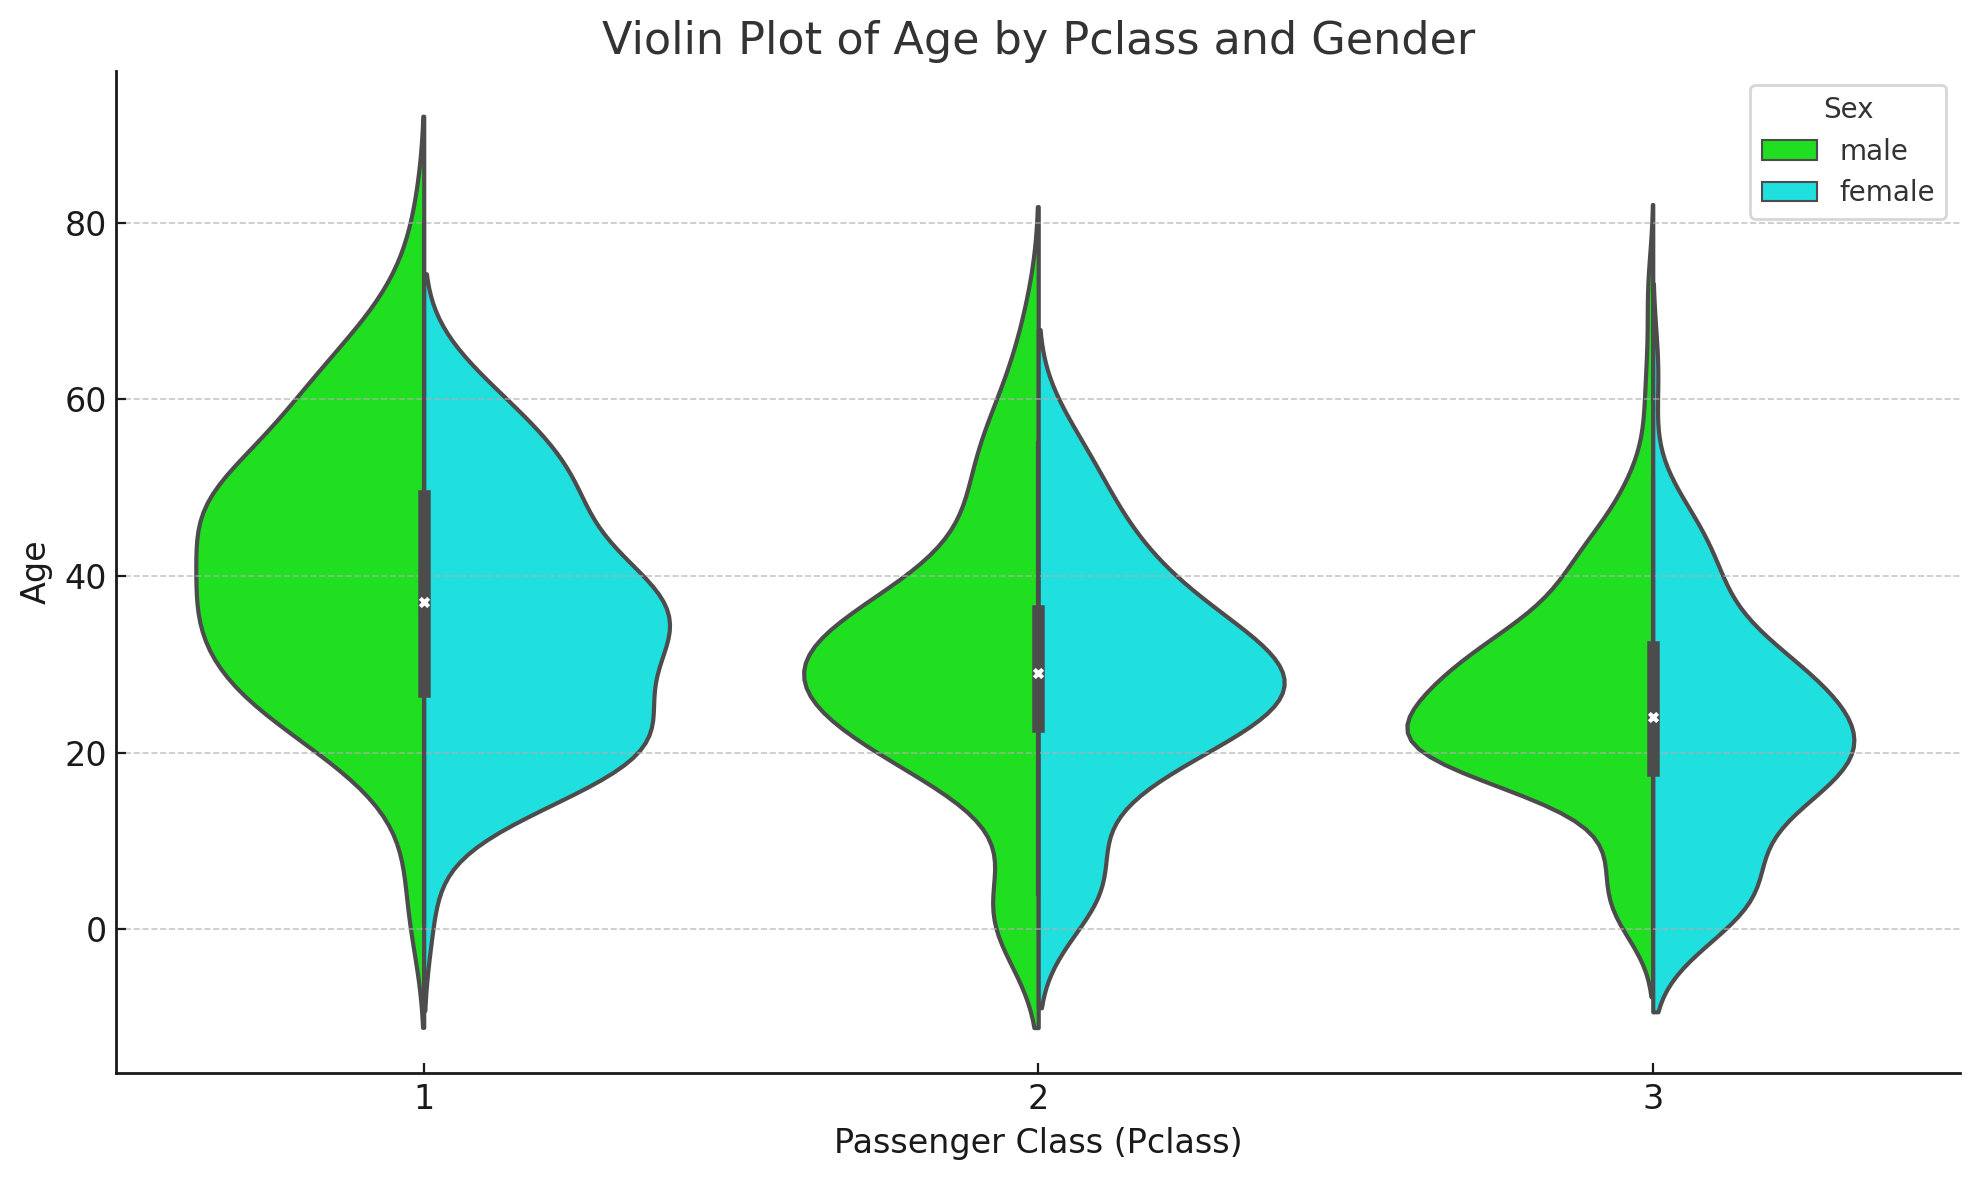

In [23]:
from IPython.display import Image, display
from pathlib import Path

file_id = img.image_file.file_id
file_name = f"./{file_id}_image_file.png"
file_path = Path.cwd() / file_name
display(Image(filename=str(file_path)))

## Example

In [24]:
# create a thread
thread = project_client.threads.create()
print(f"Created thread, thread ID: {thread.id}")

prompt = "Generate the age distribution. Use lightblue color"

# create a message
message = project_client.messages.create(
    thread_id=thread.id,
    role="user",
    content=prompt,
)
print(f"Created message, message ID: {message.id}")

Created thread, thread ID: thread_ej6GYgubHgrdqUYLCMs2B91F
Created message, message ID: msg_35rVW1ElkANumplAWWhIGUV7


In [25]:
# create a run for the agent
run = project_client.runs.create_and_process(thread_id=thread.id,
                                                   agent_id=agent.id)
print(f"Created run, run ID: {run.id}")

run.usage

Created run, run ID: run_egz9nVei9Jpqy8VZgzTOXBGj


{'prompt_tokens': 2452, 'completion_tokens': 268, 'total_tokens': 2720, 'prompt_token_details': {'cached_tokens': 0}}

In [26]:
    IMAGES_DIR = "images"

    images_list = []

    # [START get_messages_and_save_files]
    messages = project_client.messages.list(thread_id=thread.id)
    print(f"Messages: {messages}")

    for msg in messages:
        # Save every image file in the message
        for img in msg.image_contents:
            file_id = img.image_file.file_id
            file_name = f"{file_id}_image_file.png"
            project_client.files.save(file_id=file_id, file_name=file_name)
            print(f"Saved image file to: {Path.cwd() / file_name}")

        # Print details of every file-path annotation
        for ann in msg.file_path_annotations:
            print("File Paths:")
            print(f"  Type: {ann.type}")
            print(f"  Text: {ann.text}")
            print(f"  File ID: {ann.file_path.file_id}")
            print(f"  Start Index: {ann.start_index}")
            print(f"  End Index: {ann.end_index}")
        # [END get_messages_and_save_files]
        # Print last messages from the thread
        for msg in messages:
            if msg.text_messages:
                last_text = msg.text_messages[-1]
                print(f"{msg.role}: {last_text.text.value}")

Messages: <iterator object azure.core.paging.ItemPaged at 0x1172129c0>
Saved image file to: /Users/arturoquiroga/GITHUB/AZURE AI AGENT SERVICE/1_Azure Agent Service/NOTEBOOKS/assistant-JRGkmU1eD8DuRwmdvoBok3_image_file.png
MessageRole.AGENT: The file you uploaded is the Titanic dataset, and the column containing age information is `Age`.

Now, I'll generate the age distribution plot using a light blue color.
MessageRole.AGENT: I'll start by examining your uploaded file to identify the column that contains age information. Then I'll generate an age distribution plot using a light blue color.

Let's first inspect the file contents.
MessageRole.USER: Generate the age distribution. Use lightblue color


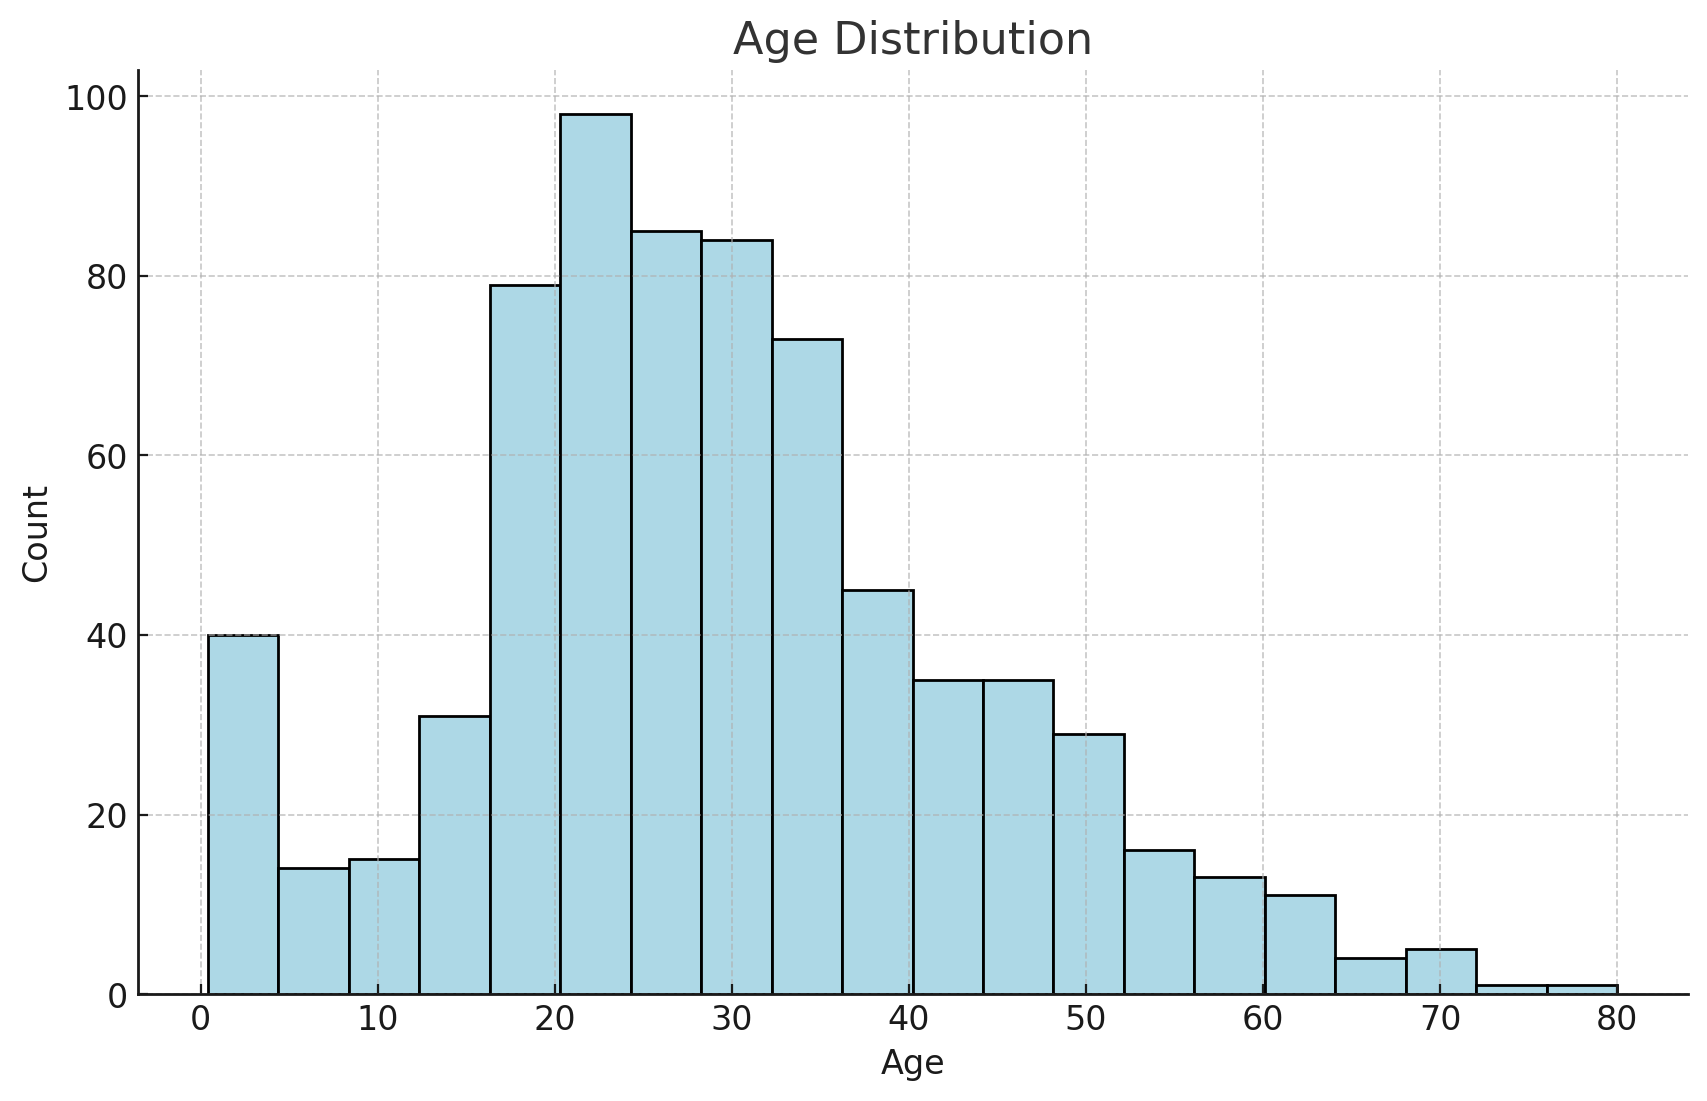

In [27]:
from IPython.display import Image, display
from pathlib import Path

file_id = img.image_file.file_id
file_name = f"./{file_id}_image_file.png"
file_path = Path.cwd() / file_name
display(Image(filename=str(file_path)))

## All images

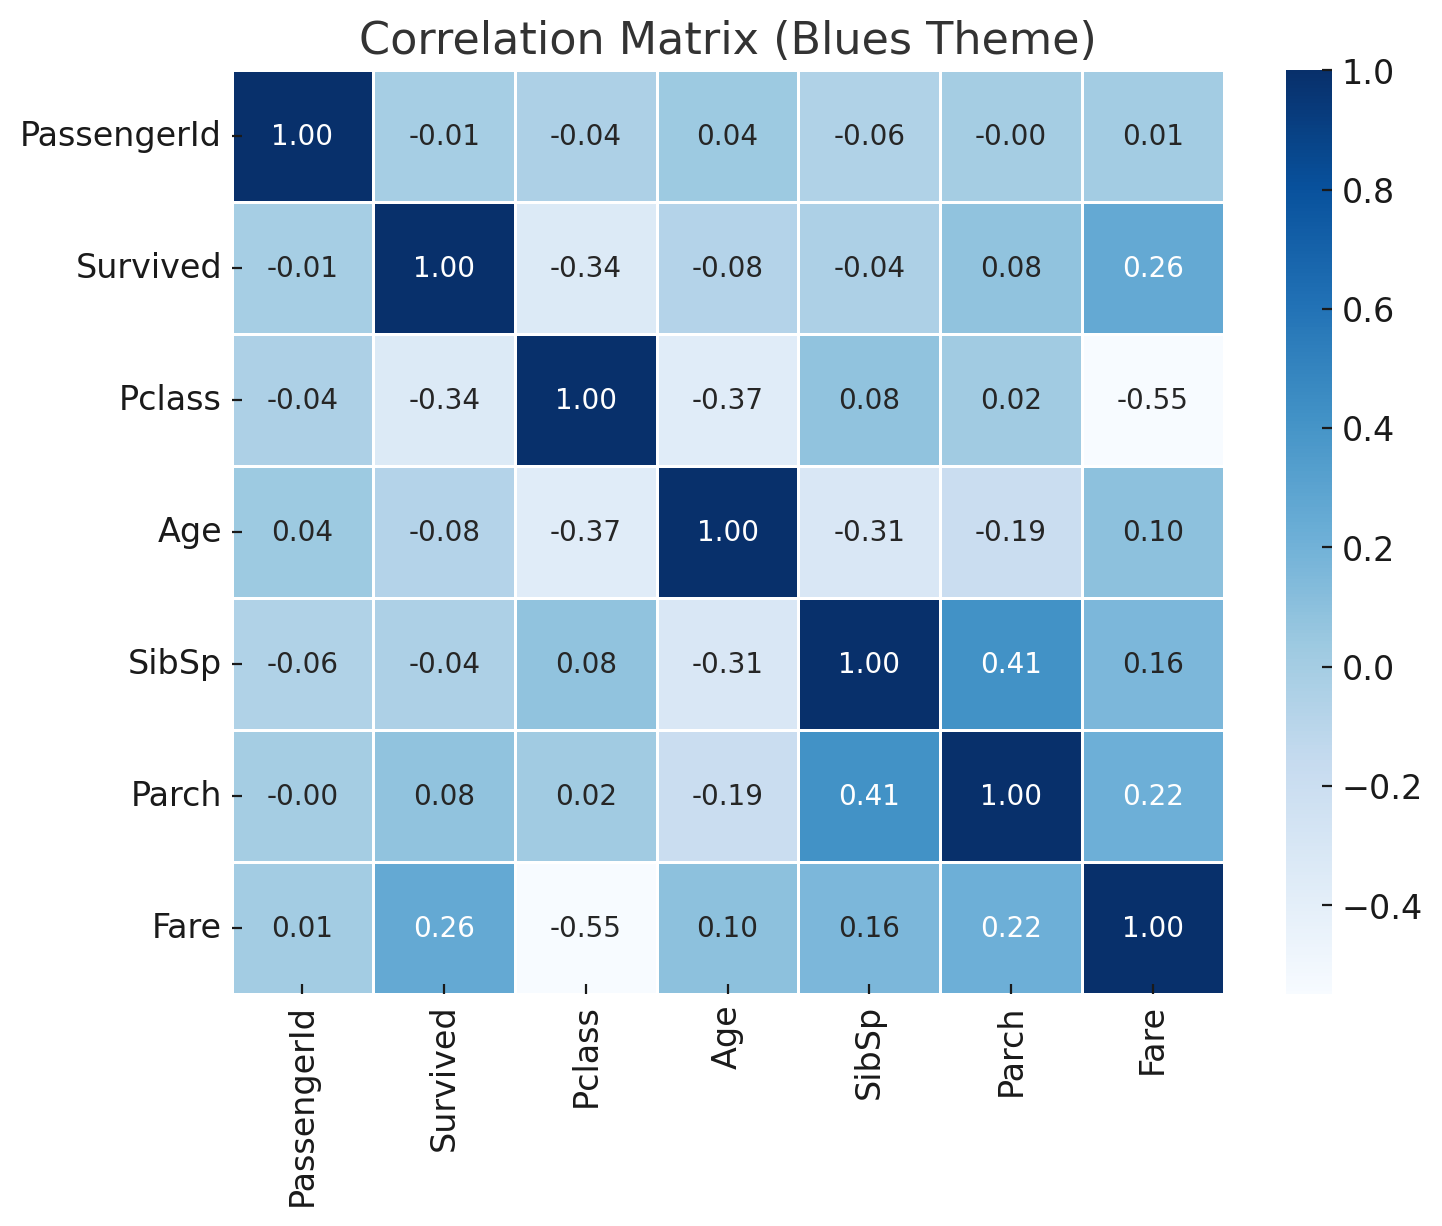

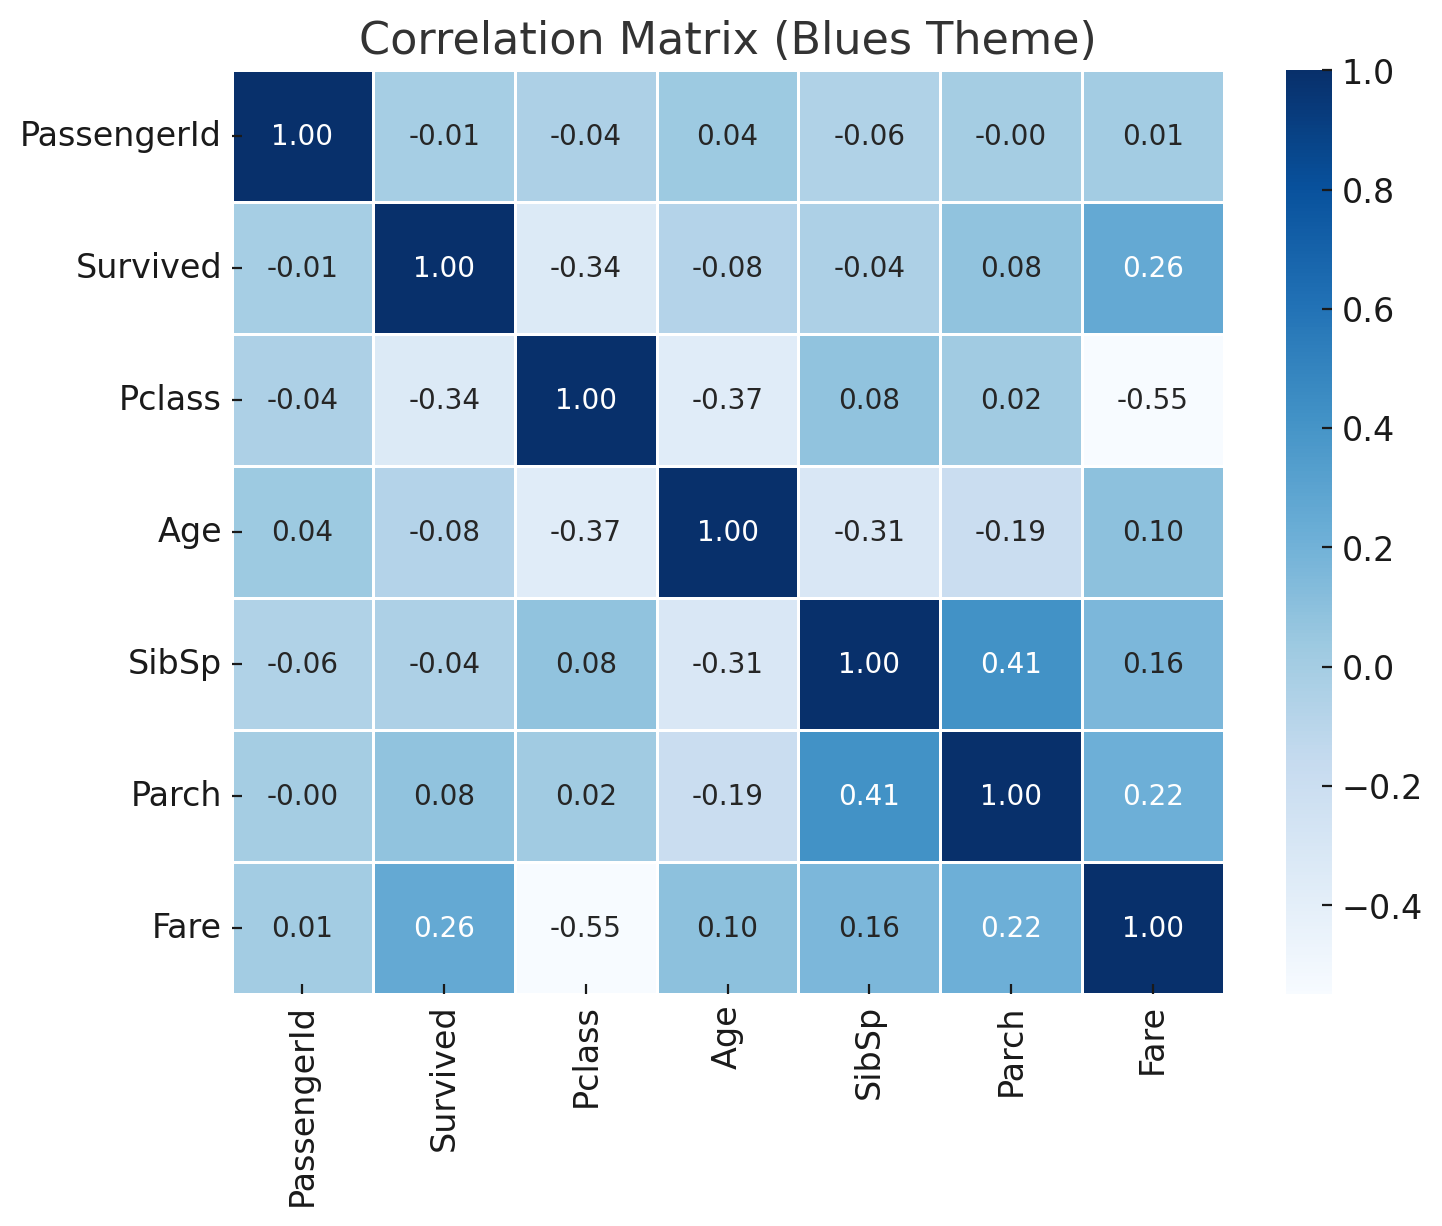

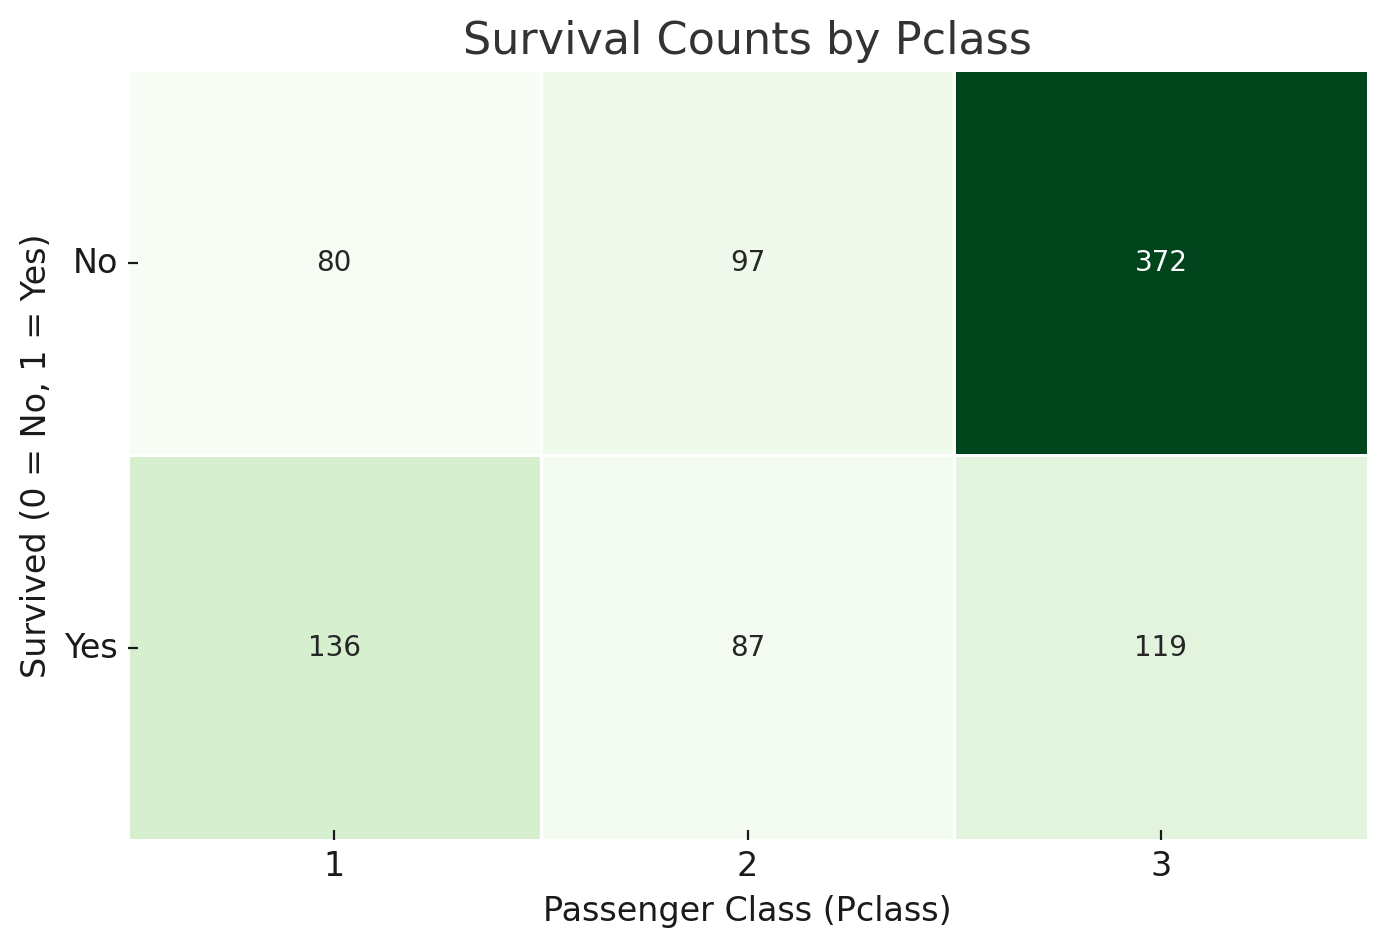

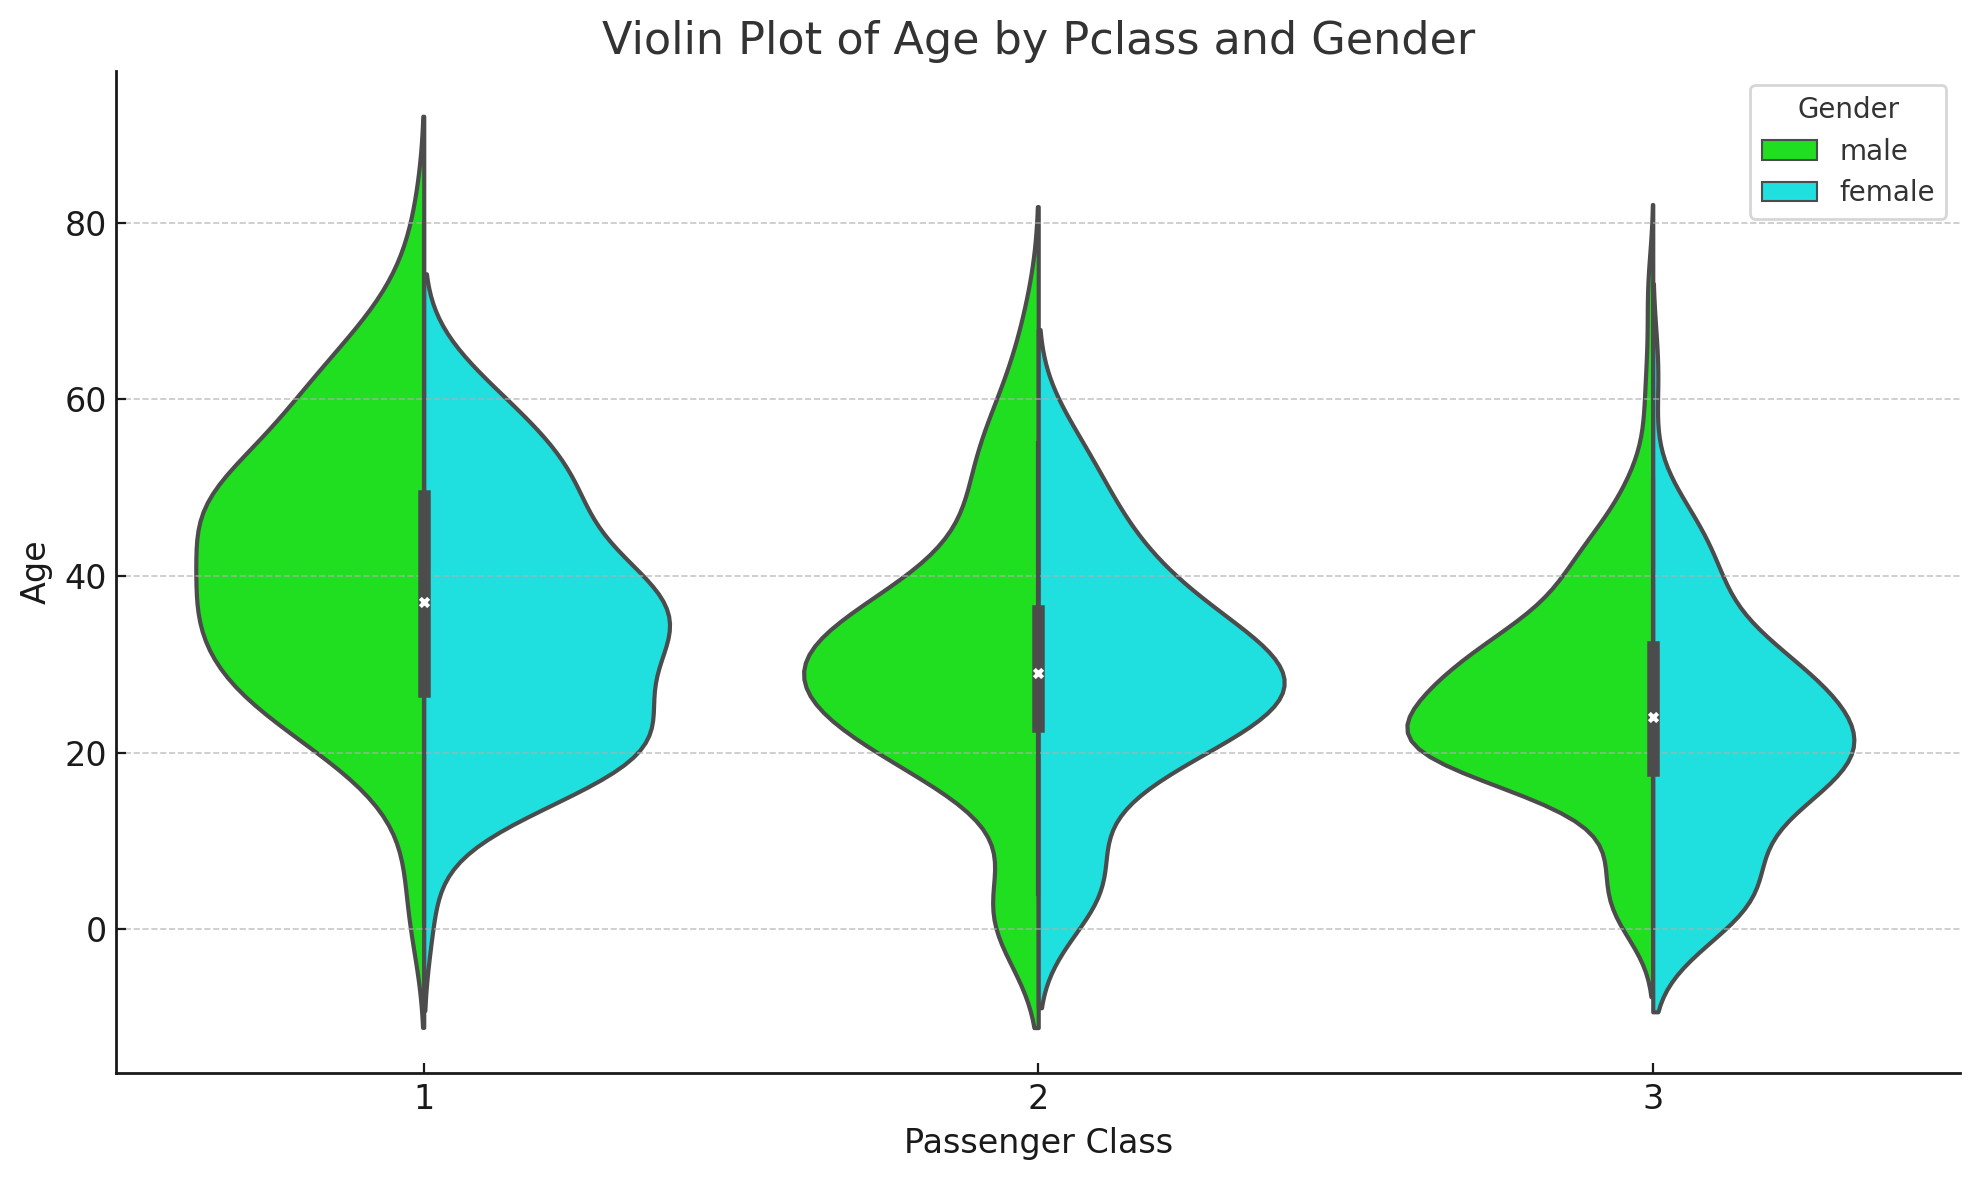

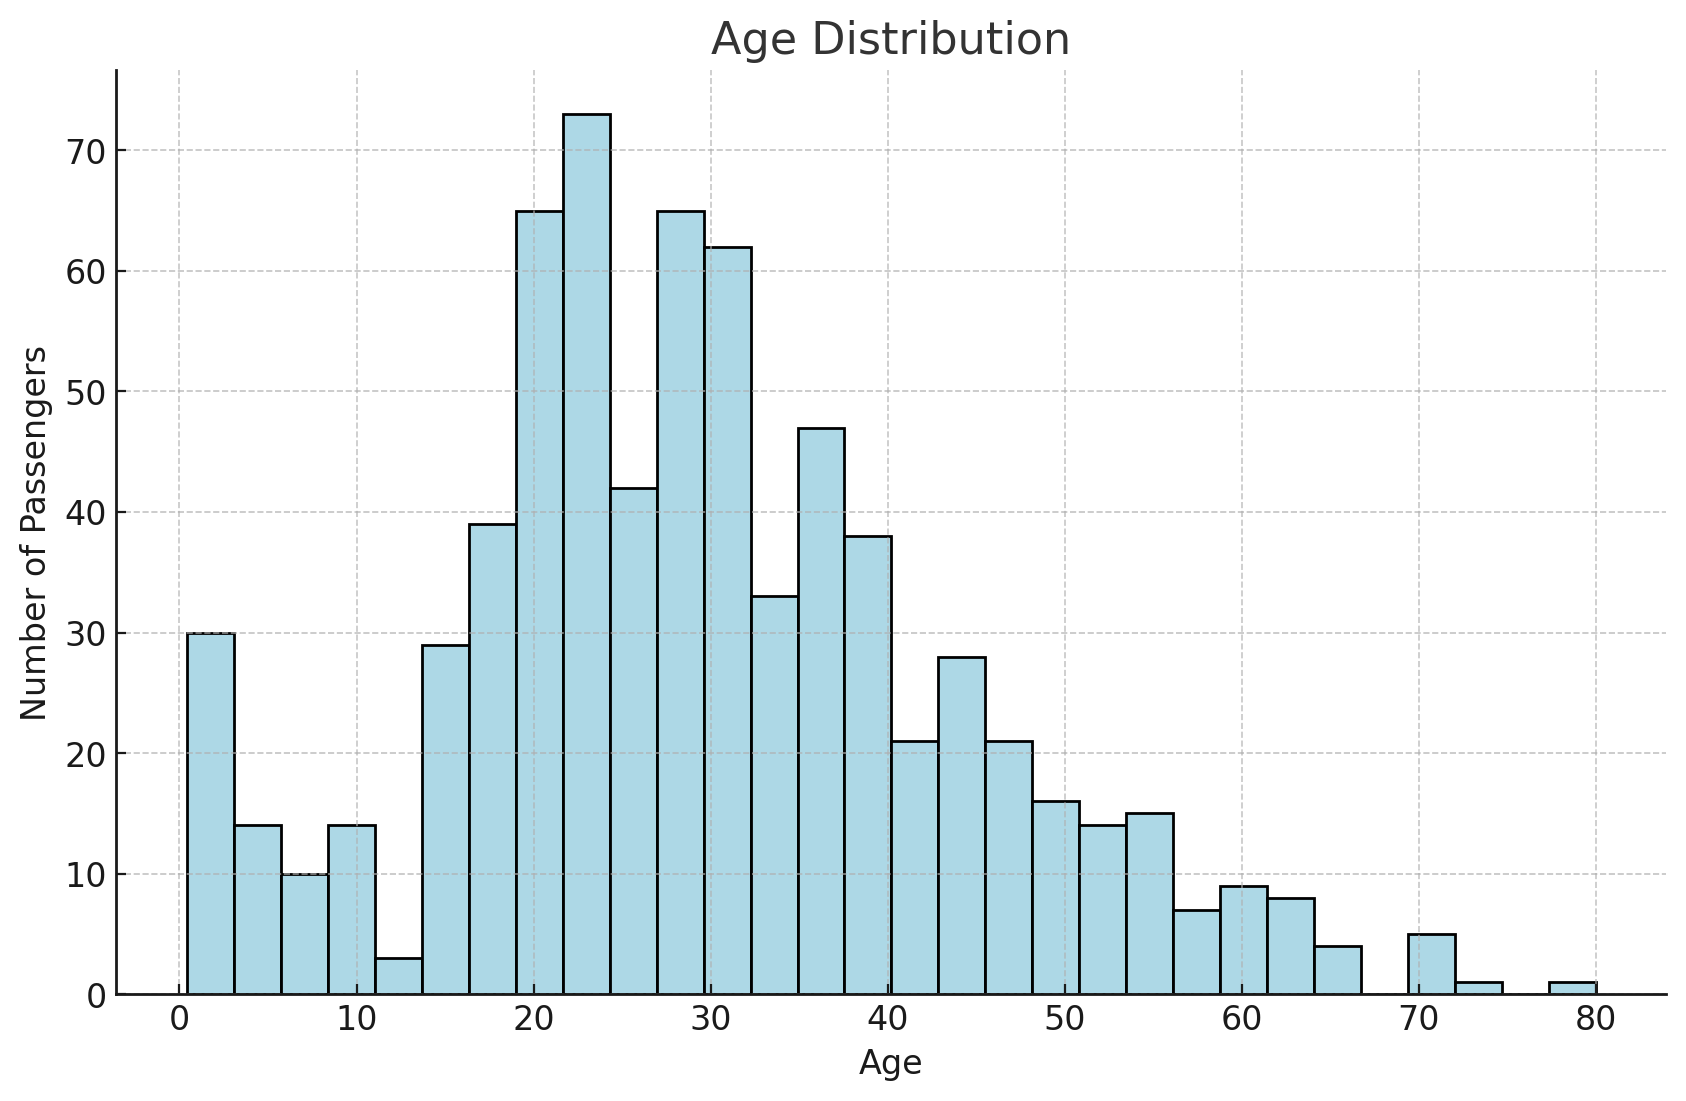

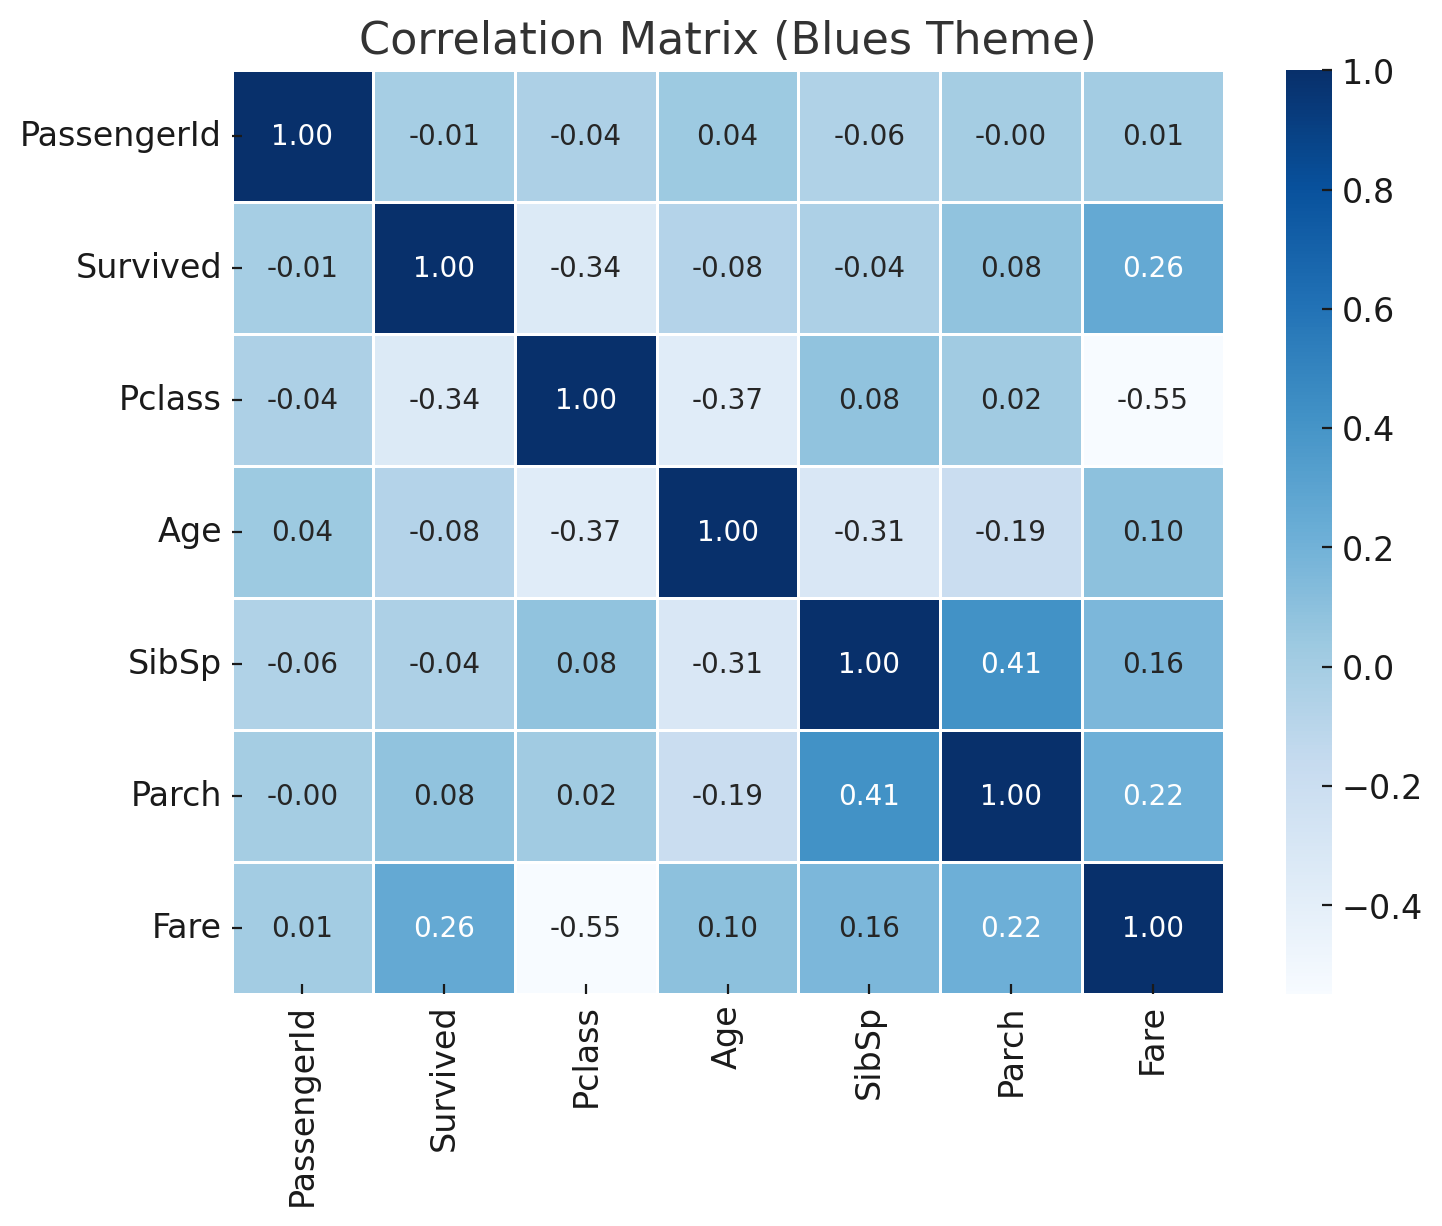

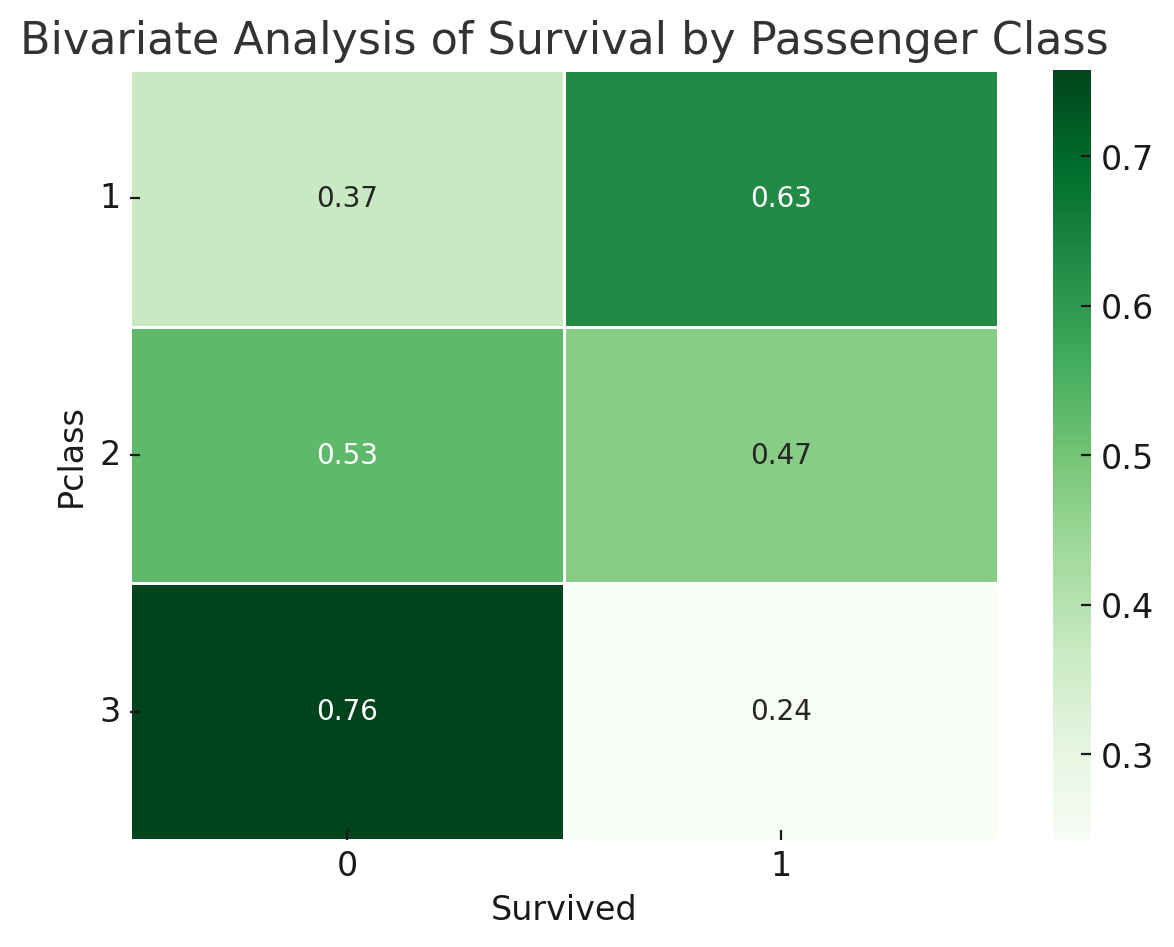

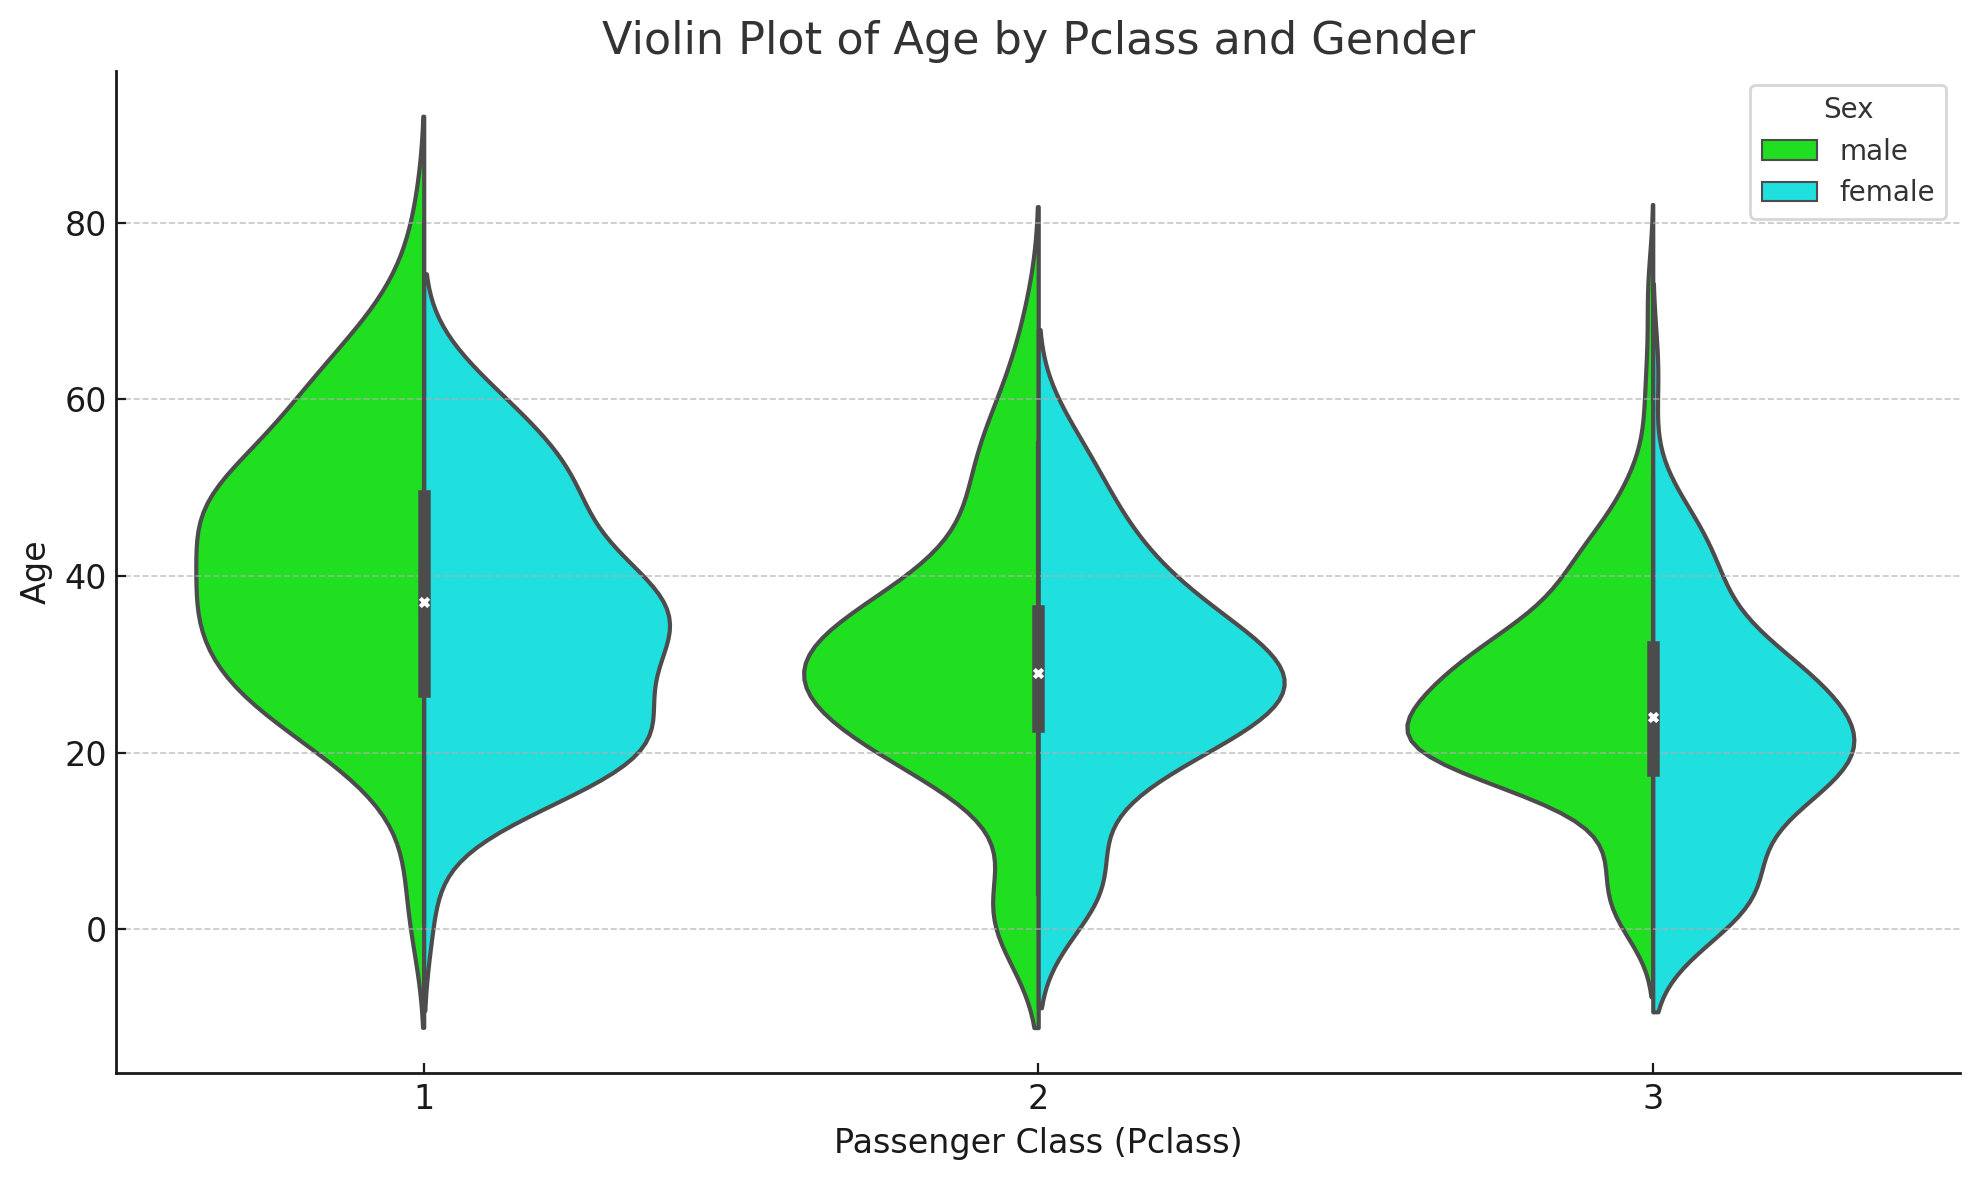

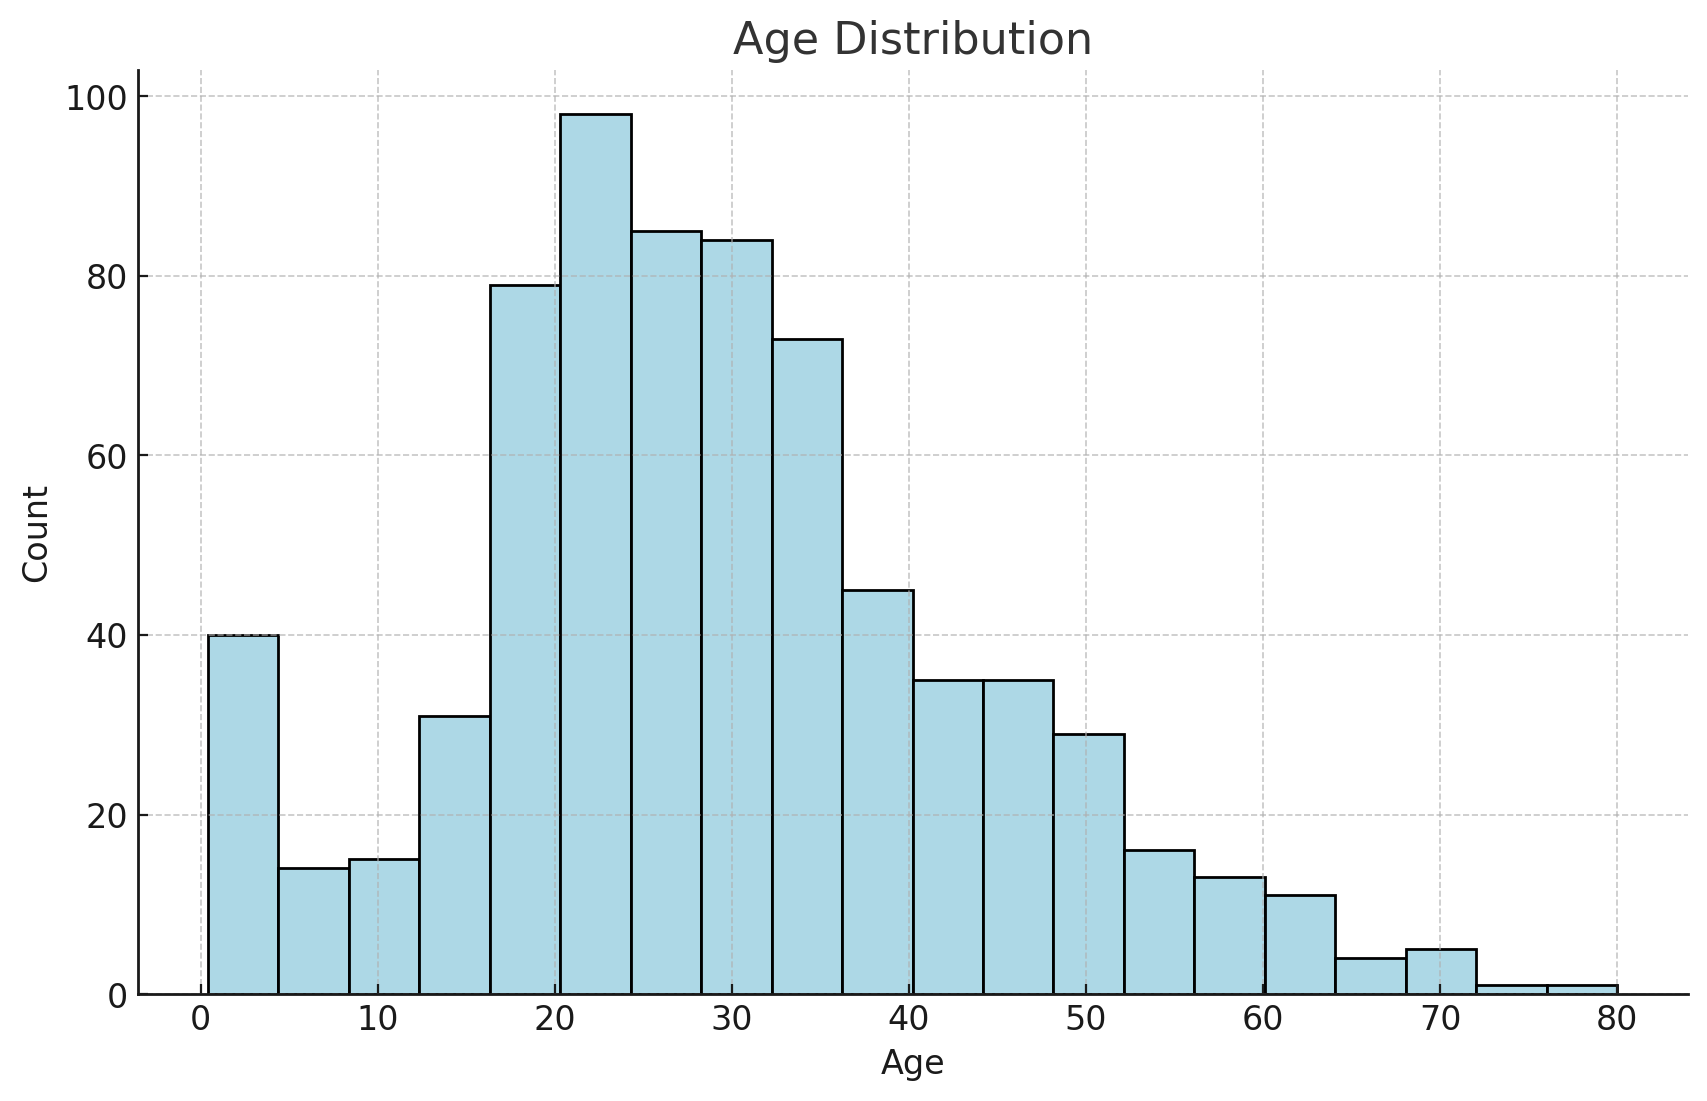

In [28]:
from IPython.display import display, Image
from pathlib import Path

# Define the directory to search for images (current working directory)
image_dir = Path.cwd()

# Find all files matching the pattern 'assistant-*.png'
image_files = sorted(
    [f for f in image_dir.glob('assistant-*.png')],
    key=lambda x: x.stat().st_mtime
)

if image_files:
    for img_path in image_files:
        display(Image(filename=str(img_path)))
else:
    print('No assistant-*.png files found in the current directory.')

## Cleaning

In [29]:
project_client.delete_agent(agent.id)
print(f"Deleted agent, agent ID: {agent.id}")

Deleted agent, agent ID: asst_qNiY8ULMtJ2DPy0wKLyN2OZp
